<a href="https://colab.research.google.com/github/MohsenSadeghi/ml_course/blob/main/notebooks/notebook_3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import pickle, urllib, glob

In [2]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

Is CUDA available: True
CUDA version: 11.6
PyTorch version: 1.13.0+cu116
CUDA device name: Tesla T4


### By chaning ```save_net``` and ```load_net``` boolean variables, you can change/access the saved weights

In [3]:
cuda0 = torch.device('cuda:0')
cpu0 = torch.device('cpu:0')

save_net = False
train_net = True
load_net = True

### The ```construct_molecule``` function can build a random cis or trans molecule-like geometry

In [4]:
def random_spherical_angles (max_theta = np.pi, max_phi = 2.0 * np.pi):
    
    return np.random.random_sample () * max_theta, np.random.random_sample () * max_phi

def spherical_coord_vector (rho, theta, phi):
    
    return rho * np.array([np.sin(theta) * np.cos(phi),
                           np.sin(theta) * np.sin(phi),
                           np.cos(theta)])

def construct_molecule (origin, bond_length, cis=True):
    
    dot_criterion = bond_length ** 2 * np.cos (0.33 * np.pi)
    
    theta , phi = random_spherical_angles()
    
    dv1 = spherical_coord_vector (bond_length, *random_spherical_angles())
    
    v1 = origin - 0.5 * dv1
    v2 = origin + 0.5 * dv1
    
    dv2 = dv1
    
    while np.dot(dv1, dv2) > dot_criterion:
        dv2 = spherical_coord_vector (bond_length, *random_spherical_angles())
    
    v3 = v2 + dv2

    if cis:
        v0 = v1 + dv2
    else:
        v0 = v1 - dv2
    
    return np.concatenate((v0, v1, v2, v3))

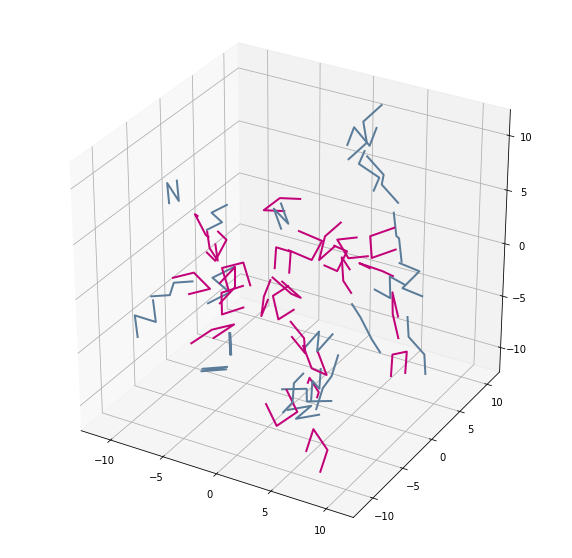

In [5]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

n_data_points = 5000
positions = []
bond_length = 2.0

origin = np.zeros(3)

for i in range (n_data_points):
    
    cis = (np.random.random_sample() < 0.5)
    color = ['xkcd:slate blue', 'xkcd:magenta'][cis]
    
    pos = construct_molecule (origin, bond_length, cis)

    if i % 100 == 0:
        p = np.array([(np.random.random_sample(3) - 0.5) * 10.0 * bond_length] * 4)
        
        ax.plot(*(p.T + pos.reshape((4, 3)).T), color=color, lw=2)
    
    positions.append(pos.copy())

positions = np.array(positions, dtype=np.float32)

plt.show ()

### This is a quick and dirty implementation of a Variational Autoencoder (VAE)

pay attention to the ```forward``` function and the reparameterization trick

In [6]:
class CisTransNet(nn.Module):

    def __init__(self, n_features,
                 encoder_layers_dim,
                 decoder_layers_dim,
                 latent_dim):

        super(CisTransNet, self).__init__()

        self.encoder = nn.ModuleList()
        current_dim = n_features
        
        for _dim in encoder_layers_dim:
            
            self.encoder.append(nn.Linear(in_features=current_dim,
                                          out_features=_dim, bias=True))
            current_dim = _dim
        
        self.bottleneck_mu = nn.Linear(current_dim, latent_dim, bias=True)
        self.bottleneck_log_var = nn.Linear(current_dim, latent_dim, bias=True)
        
        current_dim = latent_dim
        
        self.decoder = nn.ModuleList()

        for _dim in decoder_layers_dim:
            
            self.decoder.append(nn.Linear(current_dim, _dim, bias=True))
            current_dim = _dim
            
        self.final_layer = nn.Linear(current_dim, n_features, bias=True)
     
    def forward(self, x, **kwargs):

        for _lay in self.encoder:
            x = torch.relu(_lay(x, **kwargs))

        _mu = self.bottleneck_mu(x)
        _log_var = self.bottleneck_log_var(x)
        
        _sig = torch.exp(0.5 * _log_var)
        _eta = torch.randn_like(_sig)
        
        # Reparameterization trick:
        z = _eta * _sig + _mu
        
        for _lay in self.decoder:
            z = torch.relu(_lay(z, **kwargs))

        z = self.final_layer (z)
        
        return z, _mu, _log_var

### Preparing datasets to be fed to the network for training and validation

we use an 80% - 20% split between training and validation data points

In [7]:
batch_size = 256

dataset = torch.from_numpy(positions).to(cuda0)

n_train_data = int(np.ceil(0.8 * dataset.shape[0]))
n_validation_data = dataset.shape[0] - n_train_data

train_data, validation_data = torch.utils.data.random_split(dataset, [n_train_data, n_validation_data])

train_dataset = torch.utils.data.DataLoader(train_data, batch_size, drop_last=True)
validation_dataset = torch.utils.data.DataLoader(validation_data, batch_size, drop_last=True)

### Constructing an instance of the network

with the given hidden dimensions for encoder and decoder parts and limiting the latent dimensions to 2

In [8]:
net = CisTransNet (n_features=12,
                   encoder_layers_dim=[256, 128, 32, 8, 4],
                   decoder_layers_dim=[4, 8, 32, 128, 256],
                   latent_dim=2).to(cuda0)

print(net)

CisTransNet(
  (encoder): ModuleList(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=8, bias=True)
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
  (bottleneck_mu): Linear(in_features=4, out_features=2, bias=True)
  (bottleneck_log_var): Linear(in_features=4, out_features=2, bias=True)
  (decoder): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=256, bias=True)
  )
  (final_layer): Linear(in_features=256, out_features=12, bias=True)
)


### We use the good old Adam optimizer

with the learning rate of 1E-4

In [9]:
optimizer = torch.optim.AdamW(net.parameters(), lr=1.0e-4)

### The loss function

probably the most important part of the VAE.

the loss is a weighted sum of

1. reconstruction loss (to learn to reproduce the input molecule geometry)
2. KL-divergence loss (to regulate the distributions in the latent space)

In [10]:
def loss_function(input_data, output_data, _mu, _log_var, kl_weight = 0.3):
    
    reconstruction_loss = torch.nn.functional.mse_loss(output_data, input_data)

    KL_div_loss = torch.mean(-0.5 * torch.sum(1.0 + _log_var - _mu ** 2 - torch.exp(_log_var), dim = 1), dim = 0)
    
    return reconstruction_loss + kl_weight * KL_div_loss

In [11]:
n_epochs = 200
kl_weight = 0.03

gathered_loss = {'training': [], 'validation': []}

In [12]:
if load_net:
    if not glob.glob("./*.pth") or not glob.glob("./*.pickle") :

        print("Downloading network weights...")

        urllib.request.urlretrieve('https://ftp.mi.fu-berlin.de/pub/cmb-data/mohsen_data/cis_trans_vae.pth',
                                   './cis_trans_vae.pth')
        
        urllib.request.urlretrieve('https://ftp.mi.fu-berlin.de/pub/cmb-data/mohsen_data/cis_trans_vae_loss.pickle',
                                   './cis_trans_vae_loss.pickle')
    
    net.load_state_dict(torch.load("./cis_trans_vae.pth"))

    with open('./cis_trans_vae_loss.pickle', 'rb') as handle:
        gathered_loss = pickle.load(handle)

### The training loop

In [13]:
if train_net:
    
    for epoch in tqdm(range(n_epochs)):

        train_loss = []

        net.train()

        for input_data in train_dataset:

            optimizer.zero_grad()

            output_data, _mu, _log_var = net(input_data)

            _loss = loss_function(output_data, input_data, _mu, _log_var, kl_weight)

            _loss.backward()

            optimizer.step()

            train_loss.append(_loss.item())

        gathered_loss['training'].append(np.mean(train_loss))

        validation_loss = []

        net.eval()

        with torch.no_grad():

            for input_data in validation_dataset:

                optimizer.zero_grad()

                output_data, _mu, _log_var = net(input_data)

                _loss = loss_function(output_data, input_data, _mu, _log_var, kl_weight)

                validation_loss.append(_loss.item())

        gathered_loss["validation"].append(np.mean(validation_loss))

        if epoch % 10 == 0:
            print(f"epoch: {epoch} -- training loss = {gathered_loss['training'][-1]} -- validation loss = {gathered_loss['validation'][-1]}")

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0 -- training loss = 0.5150642772515615 -- validation loss = 0.5120598177115122
epoch: 10 -- training loss = 0.5041694541772207 -- validation loss = 0.5112166603406271
epoch: 20 -- training loss = 0.5010252555211385 -- validation loss = 0.5073598027229309
epoch: 30 -- training loss = 0.4966024378935496 -- validation loss = 0.5025418202082316
epoch: 40 -- training loss = 0.492874014377594 -- validation loss = 0.506406327088674
epoch: 50 -- training loss = 0.4873697022596995 -- validation loss = 0.49966780344645184
epoch: 60 -- training loss = 0.48635343710581463 -- validation loss = 0.4973426063855489
epoch: 70 -- training loss = 0.4842835903167725 -- validation loss = 0.4987597068150838
epoch: 80 -- training loss = 0.4819933871428172 -- validation loss = 0.49065398176511127
epoch: 90 -- training loss = 0.4787271022796631 -- validation loss = 0.48805079857508343
epoch: 100 -- training loss = 0.47504542072614037 -- validation loss = 0.4851236045360565
epoch: 110 -- training loss =

In [14]:
if save_net:
    torch.save(net.state_dict(), "./cis_trans_vae.pth")

    with open('./cis_trans_vae_loss.pickle', 'wb') as handle:
        pickle.dump(gathered_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

### The behavior of training and validation loss

Pay attention to the eventual saturation of the training and the start of over-fitting

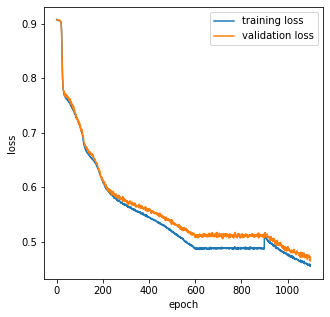

In [15]:
plt.figure(figsize=(5, 5))

for loss_type in ['training', 'validation']:
    _loss = gathered_loss[loss_type]
    
    plt.plot(np.arange(len(_loss)), _loss, label=loss_type + ' loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

### Let's take a look at the distribution of ```mu``` in the latent space

Text(0, 0.5, 'latent dim 2')

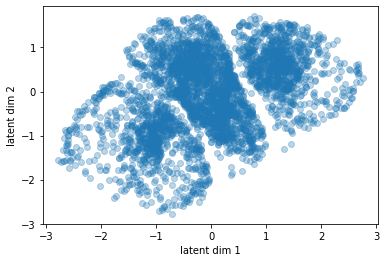

In [16]:
net.eval()

latent_points = np.empty((0, 2))

with torch.no_grad():
    
    for input_data in train_dataset:

        output_data, _mu, _log_var = net(input_data)
        
        latent_points = np.concatenate ((latent_points, _mu.to(cpu0).numpy()), axis=0)

plt.figure()
plt.scatter(latent_points[:, 0], latent_points[:, 1], alpha=0.3)
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')

### If the network is trained properly, it should be able to produce geometries similar to the input

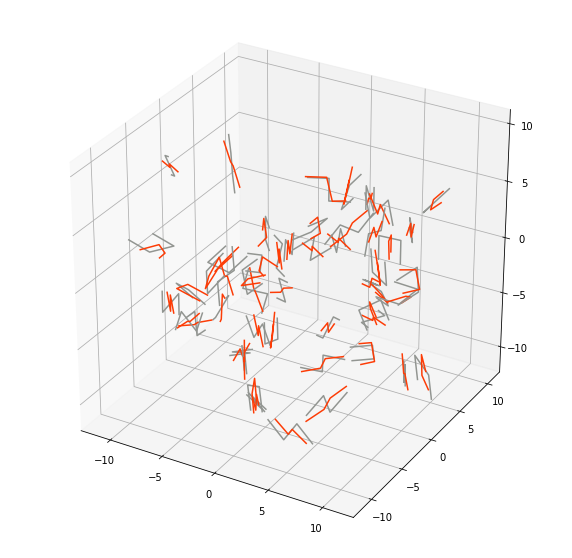

In [17]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

net.eval()

with torch.no_grad():
    
    for input_data in validation_dataset:

        output_data, _mu, _log_var = net(input_data)
    
    
    for _in_data, _out_data, i in zip(input_data, output_data, range(50)):
        
        origin = np.array([(np.random.random_sample(3) - 0.5) * 10.0 * bond_length] * 4)
        
        v_in = _in_data.to(cpu0).numpy().reshape((4, 3)) + origin
        v_out = _out_data.to(cpu0).numpy().reshape((4, 3)) + origin

        ax.plot(*v_in.T, color='xkcd:gray')
        ax.plot(*v_out.T, color='xkcd:red orange')

### The ultimate test: given new and random test data, does the network actually distinguish cis from trans?

Text(0, 0.5, 'latent dim 2')

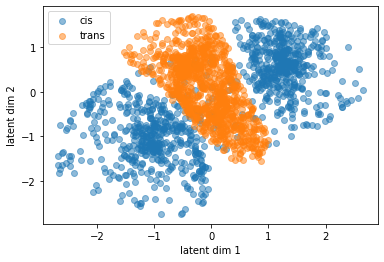

In [18]:
plt.figure()

n_points = 1000

net.eval()

with torch.no_grad():
    
    latent_points = np.empty((0, 2))
    
    for i in range(n_points):
        
        pos = construct_molecule(np.zeros(3), bond_length, cis=True).astype(np.float32).reshape((1, 12))
        
        input_data = torch.from_numpy(pos).to(cuda0)

        output_data, _mu, _log_var = net(input_data)

        latent_points = np.concatenate ((latent_points, _mu.to(cpu0).numpy()), axis=0)
        
    plt.scatter(latent_points[:, 0], latent_points[:, 1], alpha=0.5, label='cis')

    latent_points = np.empty((0, 2))
    
    for i in range(n_points):
        
        pos = construct_molecule(np.zeros(3), bond_length, cis=False).astype(np.float32).reshape((1, 12))
        
        input_data = torch.from_numpy(pos).to(cuda0)

        output_data, _mu, _log_var = net(input_data)

        latent_points = np.concatenate ((latent_points, _mu.to(cpu0).numpy()), axis=0)
        
    plt.scatter(latent_points[:, 0], latent_points[:, 1], alpha=0.5, label='trans')

plt.legend()
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')